In [102]:
import matplotlib.pyplot as plt
import networkx as nx
from queue import deque
import json

In [103]:
def export_graph(theGraph, path_dir):
    data_graph = nx.json_graph.node_link_data(theGraph)
    
    data = {
        'graph': data_graph,
    }

    with open(path_dir, 'w+') as outfile:  
        json.dump(data, outfile)

def import_graph(path_dir):
    with open(path_dir) as json_file:
        data = json.load(json_file)
        #print(data['graph'])
        graph = nx.json_graph.node_link_graph(data['graph'])
        return graph

In [104]:
def generate_order(theGraph, nodes, current_node, order, results):
    
    #print(current_node)
    #print(nodes)
    #results = []
    order.append(current_node)
    #print(order)
    if not is_order_valid(theGraph, order):
        #print('essa ordenação não é válida')
        return
    
    for node in nodes:
        #print(node)
        nodes_bkp = nodes.copy()
        nodes_bkp.remove(node)
        generate_order(theGraph, nodes_bkp, node, order.copy(), results)
        #theGraph.nodes
        #theGraph.pred[pos]
        
        #succ = list(theGraph.succ[node].keys())
        #print(nodes_bkp, succ)
        #nodes_bkp = nodes_bkp + succ
        #print(nodes_bkp)

        #current = generate_order(theGraph, nodes, max_len)
    if len(order) == len(theGraph):
        #print('order', order)
        fit, _ = generate_wsrp_matrix(theGraph, order)
        #print('results:')
        #print(results)
        #print('best', results['best']['fit'])
        #print('worst', results['worst']['fit'])
        #print('current', fit)
        if fit < results['best']['fit']:
            results['best']['fit'] = fit
            results['best']['order'] = order
        if fit > results['worst']['fit']:
            results['worst']['fit'] = fit
            results['worst']['order'] = order
        #results.append(order)

#função custosa, só usar em grafos com poucos nós
def get_best_and_worst_fitness(theGraph):
    n_nodes = len(theGraph)
    nodes = []
    
    for node in theGraph.nodes:
        nodes.append(node)
    
    #print(nodes)
    results = {'best': {'fit':n_nodes*2 + 1, 'order':[]}, 'worst':{'fit':-1, 'order':[]}}
    for edge in theGraph.in_degree:
        if edge[1] == 0:
            bkp = nodes.copy()
            bkp.remove(edge[0])
            #print('****')
            #print(edge[0])
            generate_order(theGraph, bkp, edge[0], [], results)
            #nodes.append()
    #print(nodes)
    return results
   
#theGraph = import_graph("/home/elvio/github/wsrp/graphs/problema3.txt")
#fit = get_best_and_worst_fitness(theGraph)
#print(fit['best']['fit'])
#print(fit['worst']['fit'])
#{'best': {'fit': 3}, 'worst': {'fit': 4}}

In [105]:
def plot_graph(theGraph):
    nx.draw(theGraph)
    plt.subplot(121)
    nx.draw(theGraph, with_labels=True)
    plt.show()

In [107]:
def topological_sort(theGraph):
    
    topSort = []
    q = deque() 

    for edge in theGraph.in_degree:
        if edge[1] == 0:
            q.appendleft(edge[0])
    
    while q:
        node = q.pop()
        topSort.append(node)
        for adj in theGraph.adj[node]:
            if adj not in q:
                q.appendleft(adj)
    
    return topSort

{'best': {'fit': 6, 'order': ['Pe1', 'En1', 'Ca1', 'En2', 'Pe3', 'Pe2', 'Ca3', 'Ca2', 'Pe4', 'En4']}, 'worst': {'fit': 16, 'order': ['Pe1', 'Pe2', 'Pe3', 'Pe4', 'En4', 'En1', 'En2', 'Ca2', 'Ca1', 'Ca3']}}


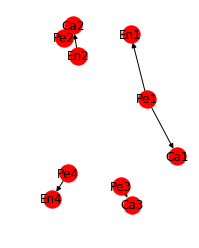

In [171]:
def mount_graph():
    
    theGraph = nx.DiGraph()   
    #Pe pedreiro
    #El eletricista
    #En encanador
    #Ca carpinteiro
    #Pi pintor 
    #Mo motorista
    #So soldador
       
    theGraph.add_node('Pe1',id=1, local='A', time=1, team='pedreiro', build='1')
    theGraph.add_node('En1',id=2, local='A', time=1, team='encanador', build='1')
    theGraph.add_node('Ca1',id=4, local='A', time=1, team='carpinteiro', build='1')
    
    theGraph.add_node('Pe2',id=5, local='B', time=1, team='pedreiro', build='1')
    theGraph.add_node('En2',id=6, local='B', time=1, team='encanador', build='1')
    theGraph.add_node('Ca2',id=7, local='B', time=1, team='carpinteiro', build='1')
    
    theGraph.add_node('Pe3',id=8, local='A', time=1, team='pedreiro', build='1')
    theGraph.add_node('Ca3',id=9, local='A', time=1, team='carpinteiro', build='1')
    
    theGraph.add_node('Pe4',id=10, local='B', time=1, team='pedreiro', build='1')
    theGraph.add_node('En4',id=11, local='B', time=1, team='encanador', build='1')
    
    
    theGraph.add_edge('Pe1','En1')
    theGraph.add_edge('Pe1','Ca1')
    theGraph.add_edge('Pe2','Ca2')
    theGraph.add_edge('En2','Ca2')
    
    theGraph.add_edge('Pe3','Ca3')
    theGraph.add_edge('Pe4','En4')
    
    return theGraph


theGraph = mount_graph()
path = "/home/elvio/github/wsrp/graphs/problema10.txt"
export_graph(theGraph, path)
theGraph = import_graph(path)
fitness = get_best_and_worst_fitness(theGraph)
print(fitness)
plot_graph(theGraph)

In [155]:
def show_schedule(schedules, order):
    print('ordenação topologica:')
    print(order, '\n')
    print('matriz de schedules:')
    
    for i in range(len(schedules)):
        print('dia:', i+1)
        for activity in schedules[i]:
            if 'deslocamento' in activity:
                print('\t', activity)
            else:
                print('\t', activity, theGraph.nodes[activity]['local'], theGraph.nodes[activity]['team'])

In [109]:
def define_work_period(theGraph, pos, teams):
    
    current_node = theGraph.nodes[pos]
    #print('*****************')
    #print(pos)
    day = 0
    previous_day = 0
    for previous in theGraph.pred[pos]:
        if not theGraph.nodes[previous]['scheduled']:
            define_work_period(theGraph, previous, teams)
        previous_day = theGraph.nodes[previous]['time'] + theGraph.nodes[previous]['day']
        
        if previous_day > day:
            day = previous_day
        #print('previous_day', previous_day, day)
    team = teams[theGraph.nodes[pos]['team']]
    #print('team:', theGraph.nodes[pos]['team'], team)
    #print(team['schedules'], len(team['schedules']))
    #print(teams)
    #print('-------------------')
    
    #if len(team['schedules']) == 0:
        #team['schedules'].update( {day : theGraph.nodes[pos]['local']})
    previous_local = None
    
    if len(team['schedules']) > 0:
        last = sorted(team['schedules'].keys())[-1]
        #print('\t', last, team['schedules'], team['schedules'][last])
        if day in team['schedules']:
            while day in team['schedules']:
                scheduled = team['schedules'][day]
                if 'deslocamento' not in scheduled:
                    previous_local = theGraph.nodes[team['schedules'][day]]['local']
                day += 1
        elif last in team['schedules']:
            previous_local = theGraph.nodes[team['schedules'][last]]['local']
            if last >= day:
                day = last + 1

        if previous_local != theGraph.nodes[pos]['local']:
            #print('deslocamento', theGraph.nodes[pos]['team'], previous_local, theGraph.nodes[pos]['local'])
            deslocamento = 'deslocamento: ' + theGraph.nodes[pos]['team'] +" "+ previous_local +" -> "+ theGraph.nodes[pos]['local']
            
            #print(team['schedules'])
            last_day = sorted(team['schedules'].keys())[-1]
            
            #print(team['schedules'][l-1])
            #print(len(team['schedules']))
            if day > last_day + 1:
                day -= 1
            team['schedules'].update( {day : deslocamento})
            #print(team['schedules'])
            
            day += 1
    team['schedules'].update({day : pos})
    #print(day)
        
    #if team['local'] != theGraph.nodes[pos]['team']:
        #theGraph.nodes[pos]['local'] = team['local']
        #day += 1
    theGraph.nodes[pos]['day'] = day
    theGraph.nodes[pos]['scheduled'] = True 
    
    #print(theGraph.nodes[pos])
    #team['schedules'].update( {day : theGraph.nodes[pos]['team']})
    #print('----------------------')
    #print('team:', theGraph.nodes[pos]['team'], team)
    #print(team['schedules'], len(team['schedules']))
    #print(teams)
    #print('-------------------')
    return day
    

def generate_wsrp_matrix(theGraph, order):
    n_nodes = len(theGraph)
    teams = {}
    for i in range(n_nodes):
        node = theGraph.nodes[order[i]]
        #print(node)
        teams.update({node['team']: {'quantity': 1, 'schedules':{}}})
        node['scheduled'] = False
        node['day'] = 0

    #for team in teams:
    #    print(team, teams[team])
        
    #schedules = []
    #day = []
    #working = []
    day = 0
    for i in range(n_nodes):
        #print('--------------------')
        #print(theGraph.nodes[order[i]])
        current_day = define_work_period(theGraph, order[i], teams)
        #print(order[i], current_day)
        if current_day > day:
            day = current_day
    
    return day+1, teams

#order = ['El2', 'Pe2', 'Pe1', 'En2', 'El1', 'En1', 'En3', 'Pe3', 'El3', 'Pi2', 'Ca1', 'Pi1', 'Ca2', 'Ca3', 'Pi3'] 
#generate_wsrp_matrix(theGraph, order)
#days, teams = generate_wsrp_matrix(theGraph, order)
#schedules = mount_schedules(theGraph, teams, days)
#show_schedule(schedules, order)

In [110]:
def mount_schedules(theGraph, teams, days):
    schedules = []
    n_nodes = len(theGraph)
    
    for i in range(days):
        schedules.append([])
    
    for team in teams:
        for schedule in teams[team]['schedules']:
            #print(teams[team]['schedules'][schedule], schedule)
            schedules[schedule].append(teams[team]['schedules'][schedule])

    return schedules

In [111]:
def is_order_valid(theGraph, order):
    n_nodes = len(order)
    
    for i in range(n_nodes):
        pos = order[i]
        for previous in theGraph.pred[pos]:
            if previous not in order:
                return False
            
            if order.index(previous) > i:
                return False
    return True
    
def tabu_search(theGraph, order, iterations, top_candidates, penalizations):
    
    best_fit, _ = generate_wsrp_matrix(theGraph, order)
    best_order = order
    best_fit_total = best_fit
    best_order_total = order
    #print('best:', best_fit, best_order)
    
    tabu_structure = []
    n_nodes = len(order)
    for i in range(n_nodes):
        tabu_structure.append([0] * n_nodes)
        #print(tabu_structure[i])
    
    candidates = {}
    has_better = True
    current_iteration = 0
    worst = 0
    worst_order = order
    
    while current_iteration < iterations and has_better: 
        for i in range(n_nodes):
            for j in range(i+1, n_nodes):
                current_order = best_order.copy()
                element_aux = current_order[i]
                current_order[i] = current_order[j]
                current_order[j] = element_aux

                is_valid = is_order_valid(theGraph, current_order)

                if is_valid:
                    fit, _ = generate_wsrp_matrix(theGraph, current_order)
                    diff = best_fit - fit
                    key = "{} {}".format(current_order[i], current_order[j])
                    candidates.update({key: [diff, fit, i, j, current_order]})
                    #print(is_valid, best_fit, fit, diff, i, j, current_order[j], current_order[i])
                    #print(best_order)
                    #print(current_order)
        
    
        #print(candidates)
        #for k, v in candidates.items():
        #    print(k, v)
        ordered_candidates = [(k, candidates[k]) for k in sorted(candidates, key=candidates.get, reverse=True)]
        len_candidates = len(ordered_candidates)
        #print()
        #print(current_iteration, len_candidates)
        #if len_candidates > 0:
        #    print('pior:', ordered_candidates[len(ordered_candidates)-1])
        if len_candidates > top_candidates:
            len_candidates = top_candidates
        
        #print('ordered:')
        #has_better = False
        for i in range(len_candidates):
            candidate = ordered_candidates[i]
            diff = candidate[1][0]
            value = candidate[1][1]
            tabu = tabu_structure[candidate[1][2]][candidate[1][3]]
            
            #print(candidate)
            #print(i, candidate[1][0], candidate[1][1], candidate[1][2], candidate[1][3], tabu)
            
            tabu_structure[candidate[1][3]][candidate[1][2]] = tabu_structure[candidate[1][3]][candidate[1][2]] + 1
            if tabu == 0 or value < best_fit_total:
                #has_better = True
                tabu_structure[candidate[1][2]][candidate[1][3]] = penalizations + 1
                if value < best_fit_total:
                    best_fit_total = value
                    best_order_total = candidate[1][4]
                if value < best_fit:
                    best_fit = value
                    best_order = candidate[1][4]
                
        for i in range(n_nodes):
            for j in range(i+1, n_nodes):
                if tabu_structure[i][j] > 0:
                    tabu_structure[i][j] -= 1
        #print('ordered:', ordered_candidates)
        #print('candidates:', candidates)
        #print('best:', days, order)
        
        #for i in range(n_nodes):
        #    print(tabu_structure[i])
        
        current_iteration += 1
    return best_fit_total, best_order_total

#iterations = 15
#top_candidates = 5
#penalizations = 3
#order = ['Pe1', 'Pe2', 'El2', 'En2', 'El1', 'En1', 'En3', 'Pe3', 'El3', 'Ca3', 'Ca1', 'Pi1', 'Ca2', 'Pi2', 'Pi3']
#order = ['Pe1', 'Pe2', 'El2', 'En3', 'El1', 'En1', 'En2', 'Pe3', 'El3', 'Ca3', 'Ca1', 'Pi1', 'Ca2', 'Pi2', 'Pi3'] 

#order = ['Pe1', 'Pe2', 'El2', 'En2', 'El1', 'En1', 'En3', 'Pe3', 'El3', 'Ca3', 'Ca1', 'Pi1', 'Ca2', 'Pi2', 'Pi3']
#days1, teams1 = generate_wsrp_matrix(theGraph, order)
#print(days1)
#fit2, order2 = tabu_search(theGraph, order, iterations, top_candidates, penalizations)
#print(fit2, order2)

#days, teams = generate_wsrp_matrix(theGraph, order2)
#schedules = mount_schedules(theGraph, teams, days)
#print(schedules)
#show_schedule(schedules, order2)

In [117]:
#train_csv = os.path.join(os.path.dirname(notebook_path), "Datasets/train.csv")
print('montando o grafo...')
theGraph = mount_graph()
export_graph(theGraph, "/home/elvio/github/wsrp/graphs/problema4.txt")
print('exportação terminada')

montando o grafo...
exportação terminada


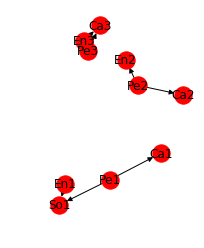

In [165]:
theGraph = import_graph("/home/elvio/github/wsrp/graphs/problema6.txt")
#limit_fitness = get_best_and_worst_fitness(theGraph)
#print(limit_fitness)
plot_graph(theGraph)

In [142]:
order = topological_sort(theGraph)
n_nodes = len(theGraph)
print(n_nodes, order)
for i in range(n_nodes):
    node = theGraph.nodes[order[i]]
    print(order[i], node)

10 ['Pe1', 'Pe2', 'So2', 'En1', 'So1', 'Pe3', 'En2', 'El1', 'Pi1', 'Pi2']
Pe1 {'local': 'A', 'time': 1, 'team': 'pedreiro', 'build': '1'}
Pe2 {'local': 'B', 'time': 1, 'team': 'pedreiro', 'build': '1'}
So2 {'local': 'B', 'time': 1, 'team': 'soldador', 'build': '1'}
En1 {'local': 'A', 'time': 1, 'team': 'encanador', 'build': '1'}
So1 {'local': 'A', 'time': 1, 'team': 'soldador', 'build': '1'}
Pe3 {'local': 'B', 'time': 1, 'team': 'pedreiro', 'build': '1'}
En2 {'local': 'B', 'time': 1, 'team': 'encanador', 'build': '1'}
El1 {'local': 'A', 'time': 1, 'team': 'eletricista', 'build': '1'}
Pi1 {'local': 'A', 'time': 1, 'team': 'pintor', 'build': '1'}
Pi2 {'local': 'B', 'time': 1, 'team': 'pintor', 'build': '1'}


In [120]:
#order = ['Pe1', 'Pe2', 'El2', 'En2', 'El1', 'En1', 'En3', 'Pe3', 'El3', 'Ca3', 'Ca1', 'Pi1', 'Ca2', 'Pi2', 'Pi3']
#order = ['El2', 'Pe2', 'Pe1', 'En2', 'El1', 'En1', 'En3', 'Pe3', 'El3', 'Pi2', 'Ca1', 'Pi1', 'Ca2', 'Ca3', 'Pi3'] 
#order = ['Pe1', 'Pe2', 'El2', 'En2', 'El1', 'En1', 'En3', 'Pe3', 'El3', 'Ca3', 'Ca1', 'Pi1', 'Ca2', 'Pi2', 'Pi3']
#order = ['Pe1', 'Pe2', 'El2', 'En2', 'El1', 'En1', 'En3', 'Pe3', 'El3', 'Ca3', 'Ca1', 'Pi1', 'Ca2', 'Pi2', 'Pi3']
#order = ['Pe1', 'Pe2', 'El2', 'En2', 'En3', 'En1', 'El1', 'Pe3', 'El3', 'Ca3', 'Ca1', 'Pi1', 'Pi3', 'Pi2', 'Ca2']
#order = ['Pe1', 'So1', 'En1', 'El2', 'En2', 'Pe3', 'Pe2']
days, teams = generate_wsrp_matrix(theGraph, order)
schedules = mount_schedules(theGraph, teams, days)
#print(schedules)
print('number of days,', days)
show_schedule(schedules, order)

'''
print(n_nodes, order)
print('n de dias', days)
for i in range(n_nodes):
    node = theGraph.nodes[order[i]]
    print(order[i], node)

for team in teams:
    #print(teams[team]['schedules'])
    print(teams[team])
'''

number of days, 5
ordenação topologica:
['Pe1', 'So1', 'En1', 'El1', 'Mo1', 'Mo2', 'Ca1', 'El2', 'Pi1'] 

matriz de schedules:
dia: 1
	 Pe1 A pedreiro
	 So1 A soldador
	 En1 A encanador
dia: 2
	 El1 A eletricista
	 Mo1 A motorista
dia: 3
	 Mo2 A motorista
	 Ca1 A carpinteiro
dia: 4
	 El2 A eletricista
dia: 5
	 Pi1 A pintor


"\nprint(n_nodes, order)\nprint('n de dias', days)\nfor i in range(n_nodes):\n    node = theGraph.nodes[order[i]]\n    print(order[i], node)\n\nfor team in teams:\n    #print(teams[team]['schedules'])\n    print(teams[team])\n"

In [121]:
iterations = 15
top_candidates = 5
penalizations = 3
#order = ['Pe1', 'Pe2', 'El2', 'En2', 'El1', 'En1', 'En3', 'Pe3', 'El3', 'Ca3', 'Ca1', 'Pi1', 'Ca2', 'Pi2', 'Pi3']
#order = ['Pe1', 'Pe2', 'El2', 'En3', 'El1', 'En1', 'En2', 'Pe3', 'El3', 'Ca3', 'Ca1', 'Pi1', 'Ca2', 'Pi2', 'Pi3'] 
#order = ['Pe1', 'Pe2', 'El2', 'En2', 'El1', 'En1', 'En3', 'Pe3', 'El3', 'Ca3', 'Ca1', 'Pi1', 'Ca2', 'Pi2', 'Pi3']
#order = ['Pe1', 'Pe2', 'El2', 'En2', 'El1', 'En1', 'En3', 'Pe3', 'El3', 'Ca3', 'Ca1', 'Pi1', 'Ca2', 'Pi2', 'Pi3']
fit, order = tabu_search(theGraph, order, iterations, top_candidates, penalizations)
print(fit, order)

days, teams = generate_wsrp_matrix(theGraph, order)
schedules = mount_schedules(theGraph, teams, days)
print(schedules)
show_schedule(schedules, order)

5 ['Pe1', 'So1', 'En1', 'El1', 'Mo1', 'Mo2', 'Ca1', 'El2', 'Pi1']
[['Pe1', 'So1', 'En1'], ['El1', 'Mo1'], ['Mo2', 'Ca1'], ['El2'], ['Pi1']]
ordenação topologica:
['Pe1', 'So1', 'En1', 'El1', 'Mo1', 'Mo2', 'Ca1', 'El2', 'Pi1'] 

matriz de schedules:
dia: 1
	 Pe1 A pedreiro
	 So1 A soldador
	 En1 A encanador
dia: 2
	 El1 A eletricista
	 Mo1 A motorista
dia: 3
	 Mo2 A motorista
	 Ca1 A carpinteiro
dia: 4
	 El2 A eletricista
dia: 5
	 Pi1 A pintor


In [131]:
iterations = 10
top_candidates = 5
penalizations = 3

In [135]:
base_path = '/home/elvio/github/wsrp/graphs/'
all_problems = ['problema1.txt', 'problema2.txt', 'problema3.txt', 'problema4.txt', 'problema11.txt', 'problema12.txt', 'problema21.txt', 'problema22.txt']
#problems = ['problema1.txt', 'problema2.txt']

n_problems = 0

for problem in all_problems:
    n_problems += 1
    theGraph = import_graph(base_path+problem)
    order = topological_sort(theGraph)
    fit_before_tabu, _ = generate_wsrp_matrix(theGraph, order)
    fit_after_tabu, order_after_tabu = tabu_search(theGraph, order, iterations, top_candidates, penalizations)
    print('########################')
    print('\t', 'problema: {}/{}'.format(n_problems, len(all_problems)))
    print('\t', problem)
    print('\t', 'fitness antes da busca tabu: {}'.format(fit_before_tabu))
    print('\t', 'fitness após a busca tabu: {}'.format(fit_after_tabu))
    print()

########################
	 problema: 1/8
	 problema1.txt
	 fitness antes da busca tabu: 4
	 fitness após a busca tabu: 3

########################
	 problema: 2/8
	 problema2.txt
	 fitness antes da busca tabu: 4
	 fitness após a busca tabu: 4

########################
	 problema: 3/8
	 problema3.txt
	 fitness antes da busca tabu: 5
	 fitness após a busca tabu: 5

########################
	 problema: 4/8
	 problema4.txt
	 fitness antes da busca tabu: 5
	 fitness após a busca tabu: 5

########################
	 problema: 5/8
	 problema11.txt
	 fitness antes da busca tabu: 7
	 fitness após a busca tabu: 7

########################
	 problema: 6/8
	 problema12.txt
	 fitness antes da busca tabu: 8
	 fitness após a busca tabu: 6

########################
	 problema: 7/8
	 problema21.txt
	 fitness antes da busca tabu: 17
	 fitness após a busca tabu: 14

########################
	 problema: 8/8
	 problema22.txt
	 fitness antes da busca tabu: 36
	 fitness após a busca tabu: 36



In [172]:
base_path = '/home/elvio/github/wsrp/graphs/'
problems = ['problema1.txt', 'problema2.txt', 'problema3.txt', 'problema4.txt', 'problema5.txt',
           'problema6.txt', 'problema7.txt', 'problema8.txt', 'problema9.txt', 'problema10.txt']
#problems = ['problema1.txt', 'problema2.txt']

n_problems = 0
worst_orders = {}

print('casos de teste com cenários pequenos, utilizando ordenação topológica')
for problem in problems:
    n_problems += 1
    
    theGraph = import_graph(base_path+problem)
    limit_fitness = get_best_and_worst_fitness(theGraph)
    order = topological_sort(theGraph)
    fit_before_tabu, _ = generate_wsrp_matrix(theGraph, order)
    fit_after_tabu, order_after_tabu = tabu_search(theGraph, order, iterations, top_candidates, penalizations)
    print('########################')
    print('\t', 'problema: {}/{}'.format(n_problems, len(problems)))
    print('\t', problem)
    print('\t', 'fitness antes da busca tabu: {}'.format(fit_before_tabu))
    print('\t', 'fitness após a busca tabu: {}'.format(fit_after_tabu))
    print('\t', 'melhor fitness global: {}'.format(limit_fitness['best']['fit']))
    print('\t', 'pior fitness global: {}'.format(limit_fitness['worst']['fit']))
    print('\t', 'pior ordenação: {}'.format(limit_fitness['worst']['order']))
    worst_orders.update({problem:[limit_fitness['best']['fit'],limit_fitness['worst']['order']]})
    print()

#print(worst_orders)

casos de teste com cenários pequenos, utilizando ordenação topológica
########################
	 problema: 1/10
	 problema1.txt
	 fitness antes da busca tabu: 4
	 fitness após a busca tabu: 3
	 melhor fitness global: 3
	 pior fitness global: 4
	 pior ordenação: ['Pb1', 'Pa1', 'En1']

########################
	 problema: 2/10
	 problema2.txt
	 fitness antes da busca tabu: 4
	 fitness após a busca tabu: 4
	 melhor fitness global: 4
	 pior fitness global: 6
	 pior ordenação: ['Pe1', 'Pe2', 'El2', 'En2', 'En1', 'Ca1', 'El1', 'Ca2']

########################
	 problema: 3/10
	 problema3.txt
	 fitness antes da busca tabu: 5
	 fitness após a busca tabu: 5
	 melhor fitness global: 5
	 pior fitness global: 7
	 pior ordenação: ['Pe1', 'So1', 'En1', 'En2', 'El2', 'Pe3', 'Pe2']

########################
	 problema: 4/10
	 problema4.txt
	 fitness antes da busca tabu: 5
	 fitness após a busca tabu: 5
	 melhor fitness global: 5
	 pior fitness global: 7
	 pior ordenação: ['Pe1', 'So1', 'En1', 'Mo1', '

In [173]:
#base_path = '/home/elvio/github/wsrp/graphs/'
#problems = ['problema1.txt', 'problema2.txt', 'problema3.txt', 'problema4.txt']
#problems = ['problema1.txt', 'problema2.txt']

n_problems = 0

print('casos de teste com cenários pequenos, utilizando o pior caso como entrada')

for key, value in worst_orders.items():
    n_problems += 1

    theGraph = import_graph(base_path+key)
    fit_before_tabu, _ = generate_wsrp_matrix(theGraph, value[1])
    fit_after_tabu, order_after_tabu = tabu_search(theGraph, value[1], iterations, top_candidates, penalizations)
    print('########################')
    print('\t', 'problema: {}/{}'.format(n_problems, len(problems)))
    print('\t', problem)
    print('\t', 'fitness antes da busca tabu: {}'.format(fit_before_tabu))
    print('\t', 'fitness após a busca tabu: {}'.format(fit_after_tabu))
    print('\t', 'melhor fitness global: {}'.format(value[0]))
    print()

casos de teste com cenários pequenos, utilizando o pior caso como entrada
########################
	 problema: 1/10
	 problema10.txt
	 fitness antes da busca tabu: 4
	 fitness após a busca tabu: 3
	 melhor fitness global: 3

########################
	 problema: 2/10
	 problema10.txt
	 fitness antes da busca tabu: 6
	 fitness após a busca tabu: 4
	 melhor fitness global: 4

########################
	 problema: 3/10
	 problema10.txt
	 fitness antes da busca tabu: 7
	 fitness após a busca tabu: 5
	 melhor fitness global: 5

########################
	 problema: 4/10
	 problema10.txt
	 fitness antes da busca tabu: 7
	 fitness após a busca tabu: 5
	 melhor fitness global: 5

########################
	 problema: 5/10
	 problema10.txt
	 fitness antes da busca tabu: 13
	 fitness após a busca tabu: 7
	 melhor fitness global: 5

########################
	 problema: 6/10
	 problema10.txt
	 fitness antes da busca tabu: 15
	 fitness após a busca tabu: 6
	 melhor fitness global: 6

##################